In [1]:
import numpy as np
from matplotlib import pyplot as plt

from qiskit import *
from qiskit.compiler import assemble
from qiskit.pulse.commands.sample_pulse import SamplePulse
from scipy.optimize import curve_fit 
import random
import math
from qiskit import pulse
from qiskit.pulse import Play
from qiskit.pulse import pulse_lib
from qiskit.providers.aer import PulseSimulator
from qiskit.providers.aer.pulse import PulseSystemModel

In [2]:
provider = IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-ornl', group='ornl', project='phy141')
backend = provider.get_backend('ibmq_johannesburg')
props, config, defaults = (backend.properties(), backend.configuration(), backend.defaults())

In [3]:
def describe_qubit(qubit, properties):
    """Print a string describing some of reported properties of the given qubit."""

    print("Qubit {0} has a \n"
          "  - T1 time of {1} microseconds\n"
          "  - T2 time of {2} microseconds\n"
          "  - U2 gate error of {3}\n"
          "  - U2 gate duration of {4} nanoseconds\n"
          "  - resonant frequency of {5} GHz".format(
              qubit,
              properties.t1(qubit) * us,
              properties.t2(qubit) * us,
              properties.gate_error('u2', qubit),
              properties.gate_length('u2', qubit) * ns,
              properties.frequency(qubit) * GHz))

In [4]:
Xp = lambda i: pulse.commands.SamplePulse([p for p in defaults.pulse_library
                 if p.name=='Xp_d'+str(i)][0].samples, 'Xp'+str(i))

In [5]:
from scipy.optimize import curve_fit

def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
#     y_fit = function(x_values, *fitparams)
    
    return fitparams, conv #, y_fit

# center data around 0
def baseline_remove(values):
    return np.array(values) - np.mean(values)

# samples need to be multiples of 16
def get_closest_multiple_of_16(num):
    return int(num + 8 ) - (int(num + 8 ) % 16)

In [6]:
qb = 0 # qubit to operate on

# Conversion factors from standard SI units
us = 1e6
ns = 1e9
GHz = 1e-9

### Collect the necessary channels
drive_chan = pulse.DriveChannel(qb)
meas_chan = pulse.MeasureChannel(qb)
acq_chan = pulse.AcquireChannel(qb)

circ_inst_map = defaults.instruction_schedule_map
measure = circ_inst_map.get('measure', qubits=qb)

describe_qubit(qb, props)

Qubit 0 has a 
  - T1 time of 87.50557033615654 microseconds
  - T2 time of 67.15301769611699 microseconds
  - U2 gate error of 0.0005146139136122981
  - U2 gate duration of 35.555555555555564 nanoseconds
  - resonant frequency of 4.664862087741449 GHz


In [50]:
shots = 1024 # determines clarity of results

period = 750 # Rabi oscillation period
cycles = [10, 80, 120, 160, 200] # number of rabi cycles to perform for each oscillation
cycles_to_plot = 10 # cycles to capture oscillation with, integer

scale_factor = 1e-14
predict_const = 54.07447683508908
predict_power = -0.9924372112785861

sig_predict_const = 11.48089749887833
sig_predict_power = -0.9672752940591574

In [51]:
# begin with no pulses in the experiment
experiments = []

data_times = []
drive_amp = np.power(period/predict_const,1/predict_power)

# make array of constant pulses that we can use to make all drive lengths
constant_pulse_lengths = [2**i for i in range(17)] # largest i that you can fit in 250,000 pulse samples
constant_pulses = []
for i in constant_pulse_lengths: 
    constant_pulses.append(pulse_lib.Constant(duration=i, amp=drive_amp))

s = lambda amp: sig_predict_const * np.power(amp, sig_predict_power)
drive_sigma = get_closest_multiple_of_16(int(s(drive_amp)))

for cycle in cycles:
    center_meas = get_closest_multiple_of_16(cycle*period)
    datapoints_per_period = period // 64 # density of datapoints in a cycle capture
    data_separation = period // datapoints_per_period

    drive_times = range(center_meas - get_closest_multiple_of_16(cycles_to_plot*data_separation*datapoints_per_period/2),
                        center_meas + get_closest_multiple_of_16(cycles_to_plot*data_separation*datapoints_per_period/2),
                        64)
    
    for i in range(len(drive_times)):  
        normal_gauss_square = pulse_lib.GaussianSquare(duration=drive_times[i], amp=drive_amp,
                            sigma=drive_sigma, width=drive_times[i]-(6*drive_sigma)).get_sample_pulse()
        front_cap = pulse.commands.SamplePulse(normal_gauss_square.samples[:3*drive_sigma], 'front_cap')
        end_cap = pulse.commands.SamplePulse(normal_gauss_square.samples[-3*drive_sigma:], 'end_cap')

        this_schedule = pulse.Schedule(name=f"Rabi duration = {i}")
        adjusted_time = get_closest_multiple_of_16(drive_times[i] - (6 * drive_sigma))

        # add front cap
        this_schedule += Play(front_cap, drive_chan)
        
        extra_time = adjusted_time
        if (adjusted_time > sum(constant_pulse_lengths)):
            while (extra_time > sum(constant_pulse_lengths)):
                this_schedule += Play(constant_pulses[-1], drive_chan)
                extra_time -= constant_pulse_lengths[-1]
            bin_time = '{0:b}'.format(extra_time)[::-1]
            for i in range(len(bin_time)):
                if (bin_time[i] == '1' and (i >= 6)):
                    this_schedule += Play(constant_pulses[i], drive_chan)
                    extra_time -= constant_pulse_lengths[i]
        else:
            bin_time = '{0:b}'.format(adjusted_time)[::-1]
            for i in range(len(bin_time)):
                if (bin_time[i] == '1' and (i >= 6)):
                    this_schedule += Play(constant_pulses[i], drive_chan)
                    extra_time -= constant_pulse_lengths[i]
                    
        # add end cap
        this_schedule += Play(end_cap, drive_chan)

        this_schedule += measure << this_schedule.duration
        experiments.append(this_schedule)

    data_times.append(drive_times)

schedule = pulse.Schedule(name='|0> state')
schedule += measure << schedule.duration
experiments.append(schedule) # add zero state to experiments
schedule = pulse.Schedule(name='|1> state')
schedule += Play(SamplePulse(Xp(qb).samples), drive_chan)
schedule += measure << schedule.duration
experiments.append(schedule) # add 1 state to experiments

In [39]:
len(experiments)

392

In [40]:
num_shots_per_point = 1024
program = assemble(experiments,
                   backend=backend,
                   meas_level=1,
                   meas_return='avg',
                   shots=num_shots_per_point)
job = backend.run(program)

In [52]:
job = backend.retrieve_job('5f089dd386d5b7001af6412d')

In [53]:
results = job.result(timeout=120)
all_results = []
for i in range(len(experiments)):
    all_results.append(np.angle(results.get_memory(i)[qb] * scale_factor, deg=True))

In [54]:
qb_rabi_data = []
all_params = []
all_fits = []
all_convs = []
num_experiments = sum([len(x) for x in data_times])

state0 = all_results[len(all_results)-2]
state1 = all_results[len(all_results)-1]

past_exp = 0
for i in range(len(cycles)):
    single_period_data = []
    for j in range(len(data_times[i])):
        # Get the results for `qubit` from the ith experiment
        single_period_data.append(all_results[past_exp+j])

    qb_rabi_data.append(single_period_data)
    past_exp += len(data_times[i])
    
    fun = lambda x, A, B, drive_period, phi: (A*np.cos(2*np.pi*x/drive_period - phi) + B)
    p, c = fit_function(list(data_times[i]), qb_rabi_data[i], fun, 
                     [np.max(qb_rabi_data[i]) - np.min(qb_rabi_data[i]), 0, period, 5])
    all_params.append(p)
    all_convs.append(c)
    
    y_fit = [fun(x, p[0], p[1], p[2], p[3]) for x in list(data_times[i])]
    
    single_period_data = np.array(single_period_data)
    # residual sum of squares
    ss_res = np.sum((single_period_data - np.array(y_fit)) ** 2)
    # total sum of squares
    ss_tot = np.sum((single_period_data - np.mean(single_period_data)) ** 2)
    # r-squared
    r2 = 1 - (ss_res / ss_tot)
    print(r2)
    
    all_fits.append(y_fit)

0.99810728011472
0.9942216175114655
0.9904384123754402
0.9828953444436843
0.9895091678269141


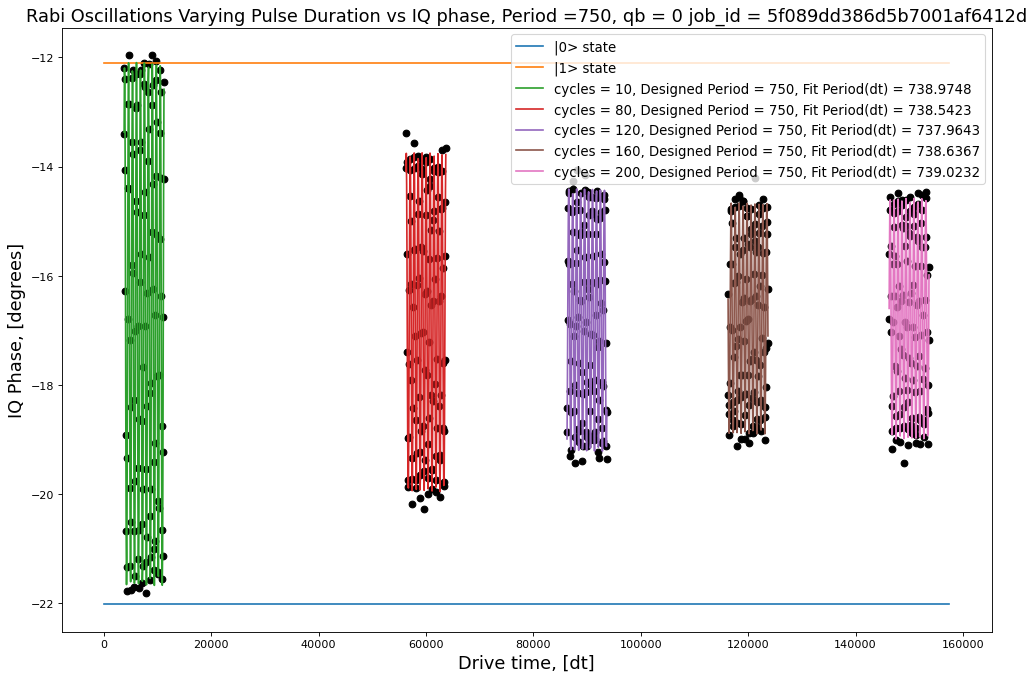

In [55]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')

start_plot_time = (period*cycles[0])-(len(data_times[0]) * 64)
end_plot_time = (period*cycles[-1])+(len(data_times[-1]) * 64)
plt.plot([start_plot_time, end_plot_time],2*[state0],label="|0> state")
plt.plot([start_plot_time, end_plot_time],2*[state1],label="|1> state")

for i in range(len(cycles)):
    plt.scatter(data_times[i], qb_rabi_data[i], color='black') # plot real part of Rabi values
    plt.plot(data_times[i], all_fits[i],
    label="cycles = " + str(cycles[i]) + ", Designed Period = " + str(period) + ", Fit Period(dt) = " + str(np.around(all_params[i][2],decimals=4)))
plt.legend(loc='upper right', fontsize=12)
plt.xlabel('Drive time, [dt]', fontsize=16)
plt.ylabel('IQ Phase, [degrees]', fontsize=16)
plt.title("Rabi Oscillations Varying Pulse Duration vs IQ phase, Period =" + str(period) + ", qb = " + str(qb) + " job_id = " + str(job.job_id()), fontsize=16)
plt.show()

In [56]:
sigma = []
for i in all_convs:
    print(i)
    perr = np.sqrt(np.diag(i))
    print(perr)
    sigma.append(perr[0])
    print()

[[ 3.85081254e-04 -3.97359017e-06  1.88816912e-05 -7.21524776e-07]
 [-3.97359017e-06  1.94032915e-04  1.34661908e-04 -1.10521487e-05]
 [ 1.88816912e-05  1.34661908e-04  2.77228628e-02 -2.39513574e-03]
 [-7.21524776e-07 -1.10521487e-05 -2.39513574e-03  2.23859717e-04]]
[0.01962349 0.01392957 0.16650184 0.01496194]

[[ 4.94941871e-04 -5.99905538e-06  9.06415924e-05 -6.14858410e-05]
 [-5.99905538e-06  2.51112936e-04  3.13662142e-04 -2.16111443e-04]
 [ 9.06415924e-05  3.13662142e-04  8.69644090e-02 -6.00961234e-02]
 [-6.14858410e-05 -2.16111443e-04 -6.00961234e-02  4.15814871e-02]]
[0.02224729 0.01584654 0.29489729 0.20391539]

[[ 4.92554187e-04 -5.51506687e-06 -3.78997755e-05  4.18533875e-05]
 [-5.51506687e-06  2.48072048e-04 -3.29172601e-04  3.43232307e-04]
 [-3.78997755e-05 -3.29172601e-04  1.40177506e-01 -1.45450346e-01]
 [ 4.18533875e-05  3.43232307e-04 -1.45450346e-01  1.51007681e-01]]
[0.02219356 0.0157503  0.37440287 0.38859707]

[[ 6.88119684e-04 -8.36985961e-08 -2.24583379e-04  3

In [57]:
for i in range(len(cycles)):
    print(f'{abs(np.array(all_params)[:,0][i])}')
print()
for i in range(len(cycles)):
    print(f'{np.max(qb_rabi_data[i])-np.min(qb_rabi_data[i])}')
print()
print(sigma)

4.7898952959527845
3.1017175466613893
2.400920253675622
2.1134905497866776
2.2022758459492593

9.857273254330583
6.883025912152785
5.373428922358936
4.910594258085068
4.959731582066432

[0.01962348731549386, 0.022247289069707563, 0.022193561831942012, 0.026232035452202453, 0.021334940970785372]


0.9885307169045433


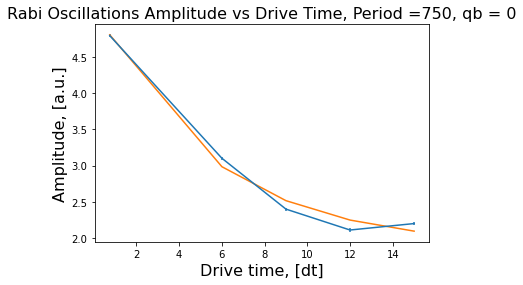

In [58]:
xvals = [(period*i)/10000 for i in cycles]
amps = abs(np.array(all_params)[:,0])
def func(x, a, b, c):
    return a * np.exp(-b * x) + c
p, conv = curve_fit(func, xvals, amps, [4, 0.1, 1], sigma)
y_fit = [func(x, p[0], p[1], p[2]) for x in xvals]

amps = np.array(amps)
# residual sum of squares
ss_res = np.sum((amps - np.array(y_fit)) ** 2)
# total sum of squares
ss_tot = np.sum((amps - np.mean(amps)) ** 2)
# r-squared
r2 = 1 - (ss_res / ss_tot)
print(r2)

plt.errorbar(xvals, amps, yerr=sigma)
plt.plot(xvals, y_fit)
plt.xlabel('Drive time, [dt]', fontsize=16)
plt.ylabel('Amplitude, [a.u.]', fontsize=16)
plt.title("Rabi Oscillations Amplitude vs Drive Time, Period =" + str(period) + ", qb = " + str(qb), fontsize=16)
plt.show()

In [59]:
print(p)
print(f'{p[1]}')
print(f'{drive_amp}')
print(conv)

[3.34342373 0.18671966 1.89466265]
0.1867196639989347
0.07066884895114885
[[ 0.06739831 -0.00611258 -0.04906927]
 [-0.00611258  0.00241526  0.01224975]
 [-0.04906927  0.01224975  0.07358804]]


0.7284445204487209


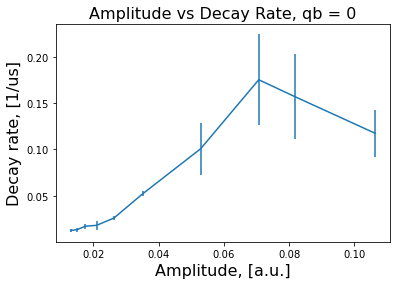

[-4.76231004  0.32559633  4.7526237 ]
[[ 17493.81145714   1212.94859882 -17494.47564973]
 [  1212.94859882     84.10273889  -1212.99482825]
 [-17494.47564973  -1212.99482825  17495.13988679]]


In [49]:
more_conv = [
[[ 0.34506242, -0.01421386, -0.36572165],
 [-0.01421386,  0.00065242,  0.01588041],
 [-0.36572165,  0.01588041,  0.3995233 ]],
[[ 0.10984199, -0.01106268, -0.104567  ],
 [-0.01106268,  0.00210535,  0.01621483],
 [-0.104567  ,  0.01621483,  0.13648073]],
[[ 0.06739831, -0.00611258, -0.04906927],
 [-0.00611258,  0.00241526,  0.01224975],
 [-0.04906927,  0.01224975,  0.07358804]],    
[[ 0.06460399, -0.0060934,  -0.07180843],
 [-0.0060934 ,  0.00077735,  0.00792731],
 [-0.07180843,  0.00792731,  0.0877013 ]],
[[ 4.14399294e-03, -1.63978965e-04, -4.49718067e-03],
 [-1.63978965e-04,  8.01854075e-06,  1.94481572e-04],
 [-4.49718067e-03,  1.94481572e-04,  5.10999376e-03]],
[[ 1.70651698e-02, -2.33798736e-04, -1.78195296e-02],
 [-2.33798736e-04,  3.47467488e-06,  2.48768010e-04],
 [-1.78195296e-02,  2.48768010e-04,  1.87234069e-02]],
[[ 1.23124968e-01, -1.63219385e-03, -1.31400770e-01],
 [-1.63219385e-03,  2.36442894e-05,  1.79138099e-03],
 [-1.31400770e-01,  1.79138099e-03,  1.41953539e-01]],
[[ 3.97893457e-02, -4.93969348e-04, -4.28446798e-02],
 [-4.93969348e-04,  7.08335339e-06,  5.61341330e-04],
 [-4.28446798e-02,  5.61341330e-04,  4.73556369e-02]],
[[ 2.64291136e-02, -2.91777081e-04, -2.89186878e-02],
 [-2.91777081e-04,  3.73667169e-06,  3.39333993e-04],
 [-2.89186878e-02,  3.39333993e-04,  3.26667167e-02]],
[[ 1.60961413e-02, -1.90900538e-04, -1.77373469e-02],
 [-1.90900538e-04,  2.76440041e-06,  2.29412480e-04],
 [-1.77373469e-02,  2.29412480e-04,  2.04852650e-02]]
]
more_sigma = [np.sqrt(np.diag(i))[1] for i in more_conv]

gammas_tilde = [0.128892878, 0.1686320417, 0.186719663, 0.112229863, 0.063628339, 0.037354941, 0.029489899, 0.028467447, 0.024708699, 0.024014088]
gammas = [g - 1/(props.t1(qb) * us) for g in gammas_tilde]
amplitudes = [0.1063313104, 0.0816299475, 0.0706688489, 0.052885571, 0.035148278, 0.026303481, 0.021007033, 0.017481556, 0.014966599, 0.013082455]

def func(x, a, b, c):
    return a * np.exp(-b * x) + c
p, pcov = curve_fit(func, amplitudes, gammas, [0, 0, 0], more_sigma, maxfev=3000)
y_fit = [func(x, p[0], p[1], p[2]) for x in amplitudes]

gammas = np.array(gammas)
# residual sum of squares
ss_res = np.sum((gammas - np.array(y_fit)) ** 2)
# total sum of squares
ss_tot = np.sum((gammas - np.mean(gammas)) ** 2)
# r-squared
r2 = 1 - (ss_res / ss_tot)
print(r2)

plt.errorbar(amplitudes, gammas, yerr=more_sigma)
# plt.plot(amplitudes, y_fit)
plt.ylabel('Decay rate, [1/us]', fontsize=16)
plt.xlabel('Amplitude, [a.u.]', fontsize=16)
plt.title("Amplitude vs Decay Rate, qb = " + str(qb), fontsize=16)
plt.show()
print(p)
print(pcov)
# print(p[0])
# print(p[1])
# print(pcov[0,0]**0.5)
# print(pcov[1,1]**0.5)

In [70]:
np.sqrt(np.diag(pcov))

array([2.51014754e-02, 8.99967757e+01, 3.34253579e-02])

[-1.89459284e+00 -1.48502308e+02  2.74458982e+03 -8.43034455e+01]


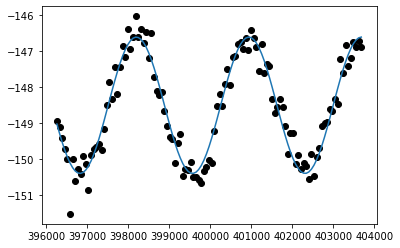

In [81]:
i = 4
plt.scatter(data_times[i], qb_rabi_data[i], color='black') # plot real part of Rabi values
plt.plot(data_times[i], all_fits[i])
print(all_params[i])